# Import necessary libraries

In [208]:
#!pip install tensorflow
#!pip install keras

In [6]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

# Import Datasets

In [173]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory('./train',image_size=(224,224), seed=42)

Found 1800 files belonging to 2 classes.


In [179]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('./validate',image_size=(224,224),seed=42)

Found 200 files belonging to 2 classes.


## Plot example images

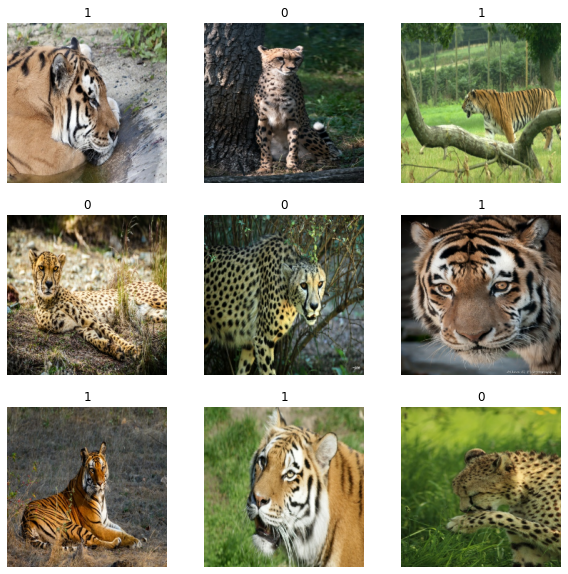

In [225]:
for image_demo in training_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(image_demo[0][i]).astype(int))
        plt.title(int(image_demo[1][i]))
        plt.axis("off")

# Generate Model

In [169]:
batch_size = 32

In [228]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Create a layer to randomly flip images or to rotate/zoom slightly
preprocessing_improvement = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

# Add layers to be trained
inputs = keras.Input(shape=(224, 224, 3))
x = preprocessing_improvement(inputs)  # Apply random data augmentation

#Need to add a normalizing layer to put inputs in the range (-1,1), (from (0,255))
#Without normalizing accuracy ~70% with normalizing its ~95%
#outputs = (inputs - mean) / sqrt(var)
normalization_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3) #255/2
variance = mean * mean
x = normalization_layer(x)
normalization_layer.set_weights([mean, variance])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_11 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_22  (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 2562      
Total params: 2,260,553
Trainable params: 2,562
Non-trainable params: 2,257,991
____________________________________________

# Train Model

In [229]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# put to 20
epochs = 1
model.fit(training_dataset, epochs=epochs)

57/57 [==============================] - 55s 910ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9203


#### Save model for later use

In [244]:
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1\assets


# Evaluate Model on validation images

In [182]:
model.evaluate(validation_dataset)

7/7 [==============================] - 5s 547ms/step - loss: 0.0066 - sparse_categorical_accuracy: 1.0000


[0.006649203132838011, 1.0]

In [240]:
image = np.asarray(Image.open('./validate/cheetah_v/cheetah_006_val_resized.jpg').resize((224,224),3))
cheetah_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))

In [183]:
model.predict(cheetah_forPrediction)
#Predictions are confidence percentage in the form [cheetah, tiger]

array([[0.9974324 , 0.00256765]], dtype=float32)

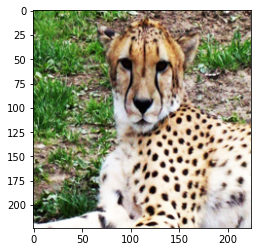

In [118]:
plt.imshow(image)

In [237]:
tiger = np.asarray(Image.open('./validate/tiger_v/tiger_005_val_resized.jpg').resize((224,224),3))
tiger_forPrediction = np.reshape(tiger,(1,tiger.shape[0],tiger.shape[1],tiger.shape[2]))

In [184]:
model.predict(tiger_forPrediction)

array([[0.00641692, 0.993583  ]], dtype=float32)

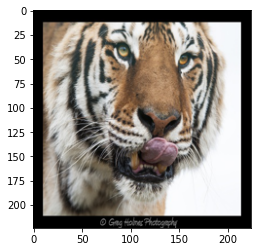

In [123]:
plt.imshow(tiger)

# Part 3 Find interesting neurons/channels

In [207]:
#base_model.summary()

In [216]:
global_pooling = keras.layers.GlobalAveragePooling2D()
#1280 for the number of neurons
softmax_layer = keras.layers.Softmax()

neuronSearch = keras.Sequential(
    [
        base_model,
        global_pooling,
        softmax_layer        
    ]
)
neuronSearch.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_19  (None, 1280)              0         
_________________________________________________________________
softmax_1 (Softmax)          (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [241]:
cheetah_arr = neuronSearch.predict(cheetah_forPrediction)

In [242]:
#Find the maximum value of the softmax output and get the index of it
maxVal = cheetah_arr.max()
index = np.where(cheetah_arr == maxVal)
index
#Examples for cheetah 515, 511, 14

(array([0], dtype=int64), array([14], dtype=int64))

In [243]:
#Function to find neurons that are strongly correlated with the class labels
#Probably do this by looping over and predicting images for both classes
#for each prediction find the index of the highest softmax output for the image
#add the index of this "channel" to a list
#Depending on how many images are considered, see if any nodes were correlated frequently and use those


# Part 4: Object Localization

In [ ]:
#need to figure out how to access channel of base model once index is obtained


#using interesting channels obtained from part 3 (Examples for cheetah 515, 511, 14)
#visualize 2d output
#comment on if it coould allow localisation of objects in the input image.
#several examples and corresponding 2d outputs.